In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
from tensorflow import keras
import helper
from tfomics import utils, explain, metrics

Using TensorFlow backend.


In [2]:

import pandas as pd
import logomaker

def plot_filers(W, num_cols=8, figsize=(30,5)):

    num_filters = len(W)
    num_widths = int(np.ceil(num_filters/num_cols))

    fig = plt.figure(figsize=figsize)
    fig.subplots_adjust(hspace=0.1, wspace=0.1)

    logos = []
    for n, w in enumerate(W):
        ax = fig.add_subplot(num_widths, num_cols, n+1)
        #if (np.sum(w) != 0) | (np.sum(np.isnan(w) == True) > 0):
        
        # calculate sequence logo heights
        I = np.log2(4) + np.sum(w * np.log2(w+1e-7), axis=1, keepdims=True)
        logo = I*w

        L, A = w.shape
        counts_df = pd.DataFrame(data=0.0, columns=list('ACGT'), index=list(range(L)))
        for a in range(A):
            for l in range(L):
                counts_df.iloc[l,a] = logo[l,a]

        logomaker.Logo(counts_df, ax=ax)
        ax = plt.gca()
        ax.spines['right'].set_visible(False)
        ax.spines['top'].set_visible(False)
        ax.yaxis.set_ticks_position('none')
        ax.xaxis.set_ticks_position('none')
        plt.xticks([])
        plt.yticks([])
        
        logos.append(logo)
        
    return fig, W, logo

In [3]:
# load dataset
data_path = '../data/synthetic_dataset.h5'
data = helper.load_dataset(data_path)
x_train, y_train, x_valid, y_valid, x_test, y_test = data

In [64]:
import tensorflow as tf
from tensorflow import keras
from keras import backend as K
from tfomics import layers, utils
keras.backend.clear_session()

pool_size=[2, 50]
activation='relu'

l2 = 1e-6
dropout = [0.1, 0.1, 0.5]
bn = True
    
multiplier = 1
dropout_block0 = 0.1
dropout_block1 = 0.2
dropout_block2 = 0.3
dropout_block3 = 0.4
dropout_block4 = 0.5

# input layer
inputs = keras.layers.Input(shape=(200,4))


def l2_reg(weight_matrix):
#    return 0.25 * K.sum(K.square(weight_matrix))
     return 0.25 * K.sum(K.square(weight_matrix))

def max_1(x):
    #return K.relu(x)
    return K.log(K.square(x)+1e-10)*(x+1)*.25+.25

# block 1
nn = keras.layers.Conv1D(filters=32,
                         kernel_size=19,
                         strides=1,
                         activation=None,
                         use_bias=False,
                         padding='same',
                         kernel_regularizer=l2_reg, 
                         #kernel_initializer=keras.initializers.RandomNormal(mean=1.0, stddev=0.2),
                         )(inputs)        
nn = keras.layers.BatchNormalization()(nn)
#nn = keras.layers.LayerNormalization()(nn)
activation = utils.activation_fn('log_relu')
nn = keras.layers.Activation(activation)(nn)
#nn = keras.layers.Activation('relu')(nn)
nn = keras.layers.Dropout(dropout_block0)(nn)
nn = layers.conv_layer(nn,
                       num_filters=48*multiplier, 
                       kernel_size=7,   #176
                       padding='same', 
                       activation='relu', 
                       dropout=dropout_block1,
                       l2=l2, 
                       bn=bn)
nn = keras.layers.MaxPool1D(pool_size=4, 
                            strides=4,   # 50
                            padding='same'
                            )(nn)

nn = layers.conv_layer(nn,
                       num_filters=96*multiplier, 
                       kernel_size=7,     # 44
                       padding='valid', 
                       activation='relu', 
                       dropout=dropout_block1,
                       l2=l2, 
                       bn=bn)
nn = keras.layers.MaxPool1D(pool_size=4,  # 11
                            strides=4, 
                            padding='same'
                            )(nn)

nn = layers.conv_layer(nn,
                       num_filters=128*multiplier, 
                       kernel_size=3,   # 9
                       padding='valid', 
                       activation='relu', 
                       dropout=dropout_block2,
                       l2=l2, 
                       bn=bn)
nn = keras.layers.MaxPool1D(pool_size=3,  # 3
                            strides=3, 
                            padding='same'
                            )(nn)

# Fully-connected NN
nn = keras.layers.Flatten()(nn)
nn = layers.dense_layer(nn, num_units=512, activation='relu', 
                        dropout=dropout[2], l2=l2, bn=bn)

# Output layer - additive + learned non-linearity
logits = keras.layers.Dense(12, activation='linear', use_bias=True,  
                             kernel_initializer='glorot_normal',
                             bias_initializer='zeros')(nn)
outputs = keras.layers.Activation('sigmoid')(logits)

model = keras.Model(inputs=inputs, outputs=outputs)



In [65]:

# set up optimizer and metrics
auroc = keras.metrics.AUC(curve='ROC', name='auroc')
aupr = keras.metrics.AUC(curve='PR', name='aupr')
optimizer = keras.optimizers.Adam(learning_rate=0.001)
loss = keras.losses.BinaryCrossentropy(from_logits=False, label_smoothing=0)
model.compile(optimizer=optimizer,
              loss=loss,
              metrics=['accuracy', auroc, aupr])


es_callback = keras.callbacks.EarlyStopping(monitor='val_auroc', #'val_aupr',#
                                            patience=20, 
                                            verbose=1, 
                                            mode='max', 
                                            restore_best_weights=False)
reduce_lr = keras.callbacks.ReduceLROnPlateau(monitor='val_auroc', 
                                              factor=0.2,
                                              patience=5, 
                                              min_lr=1e-7,
                                              mode='max',
                                              verbose=1) 

history = model.fit(x_train, y_train, 
                    epochs=100,
                    batch_size=100, 
                    shuffle=True,
                    validation_data=(x_valid, y_valid), 
                    callbacks=[es_callback, reduce_lr])

Train on 21000 samples, validate on 3000 samples
Epoch 1/100
21000/21000 [==============================] - 2s 103us/sample - loss: 0.8511 - acc: 0.8324 - auroc: 0.5114 - aupr: 0.1505 - val_loss: 0.5026 - val_acc: 0.8557 - val_auroc: 0.4949 - val_aupr: 0.1429
Epoch 2/100
21000/21000 [==============================] - 2s 75us/sample - loss: 0.4676 - acc: 0.8559 - auroc: 0.5859 - aupr: 0.2311 - val_loss: 0.5855 - val_acc: 0.8557 - val_auroc: 0.4935 - val_aupr: 0.1423
Epoch 3/100
21000/21000 [==============================] - 2s 72us/sample - loss: 0.4069 - acc: 0.8645 - auroc: 0.6702 - aupr: 0.3343 - val_loss: 0.5742 - val_acc: 0.8557 - val_auroc: 0.5011 - val_aupr: 0.1433
Epoch 4/100
21000/21000 [==============================] - 2s 75us/sample - loss: 0.3663 - acc: 0.8732 - auroc: 0.7376 - aupr: 0.4315 - val_loss: 0.4692 - val_acc: 0.8578 - val_auroc: 0.6012 - val_aupr: 0.2066
Epoch 5/100
21000/21000 [==============================] - 2s 76us/sample - loss: 0.3376 - acc: 0.8837 - auroc

Epoch 40/100
21000/21000 [==============================] - 2s 82us/sample - loss: 0.2351 - acc: 0.9257 - auroc: 0.9295 - aupr: 0.7918 - val_loss: 0.2408 - val_acc: 0.9202 - val_auroc: 0.9341 - val_aupr: 0.7949
Epoch 41/100
20400/21000 [============================>.] - ETA: 0s - loss: 0.2335 - acc: 0.9263 - auroc: 0.9302 - aupr: 0.7949
Epoch 00041: ReduceLROnPlateau reducing learning rate to 0.00020000000949949026.
21000/21000 [==============================] - 2s 80us/sample - loss: 0.2338 - acc: 0.9262 - auroc: 0.9301 - aupr: 0.7946 - val_loss: 0.2409 - val_acc: 0.9187 - val_auroc: 0.9342 - val_aupr: 0.7928
Epoch 42/100
21000/21000 [==============================] - 2s 72us/sample - loss: 0.2109 - acc: 0.9334 - auroc: 0.9428 - aupr: 0.8271 - val_loss: 0.2263 - val_acc: 0.9204 - val_auroc: 0.9447 - val_aupr: 0.8281
Epoch 43/100
21000/21000 [==============================] - 2s 76us/sample - loss: 0.2058 - acc: 0.9342 - auroc: 0.9439 - aupr: 0.8308 - val_loss: 0.2110 - val_acc: 0.9285

20400/21000 [============================>.] - ETA: 0s - loss: 0.1654 - acc: 0.9468 - auroc: 0.9619 - aupr: 0.8821
Epoch 00076: ReduceLROnPlateau reducing learning rate to 1.6000001778593287e-06.
21000/21000 [==============================] - 2s 78us/sample - loss: 0.1656 - acc: 0.9468 - auroc: 0.9617 - aupr: 0.8817 - val_loss: 0.1723 - val_acc: 0.9414 - val_auroc: 0.9678 - val_aupr: 0.8875
Epoch 77/100
21000/21000 [==============================] - 2s 82us/sample - loss: 0.1658 - acc: 0.9464 - auroc: 0.9618 - aupr: 0.8814 - val_loss: 0.1720 - val_acc: 0.9416 - val_auroc: 0.9679 - val_aupr: 0.8877
Epoch 78/100
21000/21000 [==============================] - 2s 76us/sample - loss: 0.1650 - acc: 0.9468 - auroc: 0.9623 - aupr: 0.8826 - val_loss: 0.1722 - val_acc: 0.9415 - val_auroc: 0.9678 - val_aupr: 0.8875
Epoch 79/100
21000/21000 [==============================] - 2s 86us/sample - loss: 0.1655 - acc: 0.9466 - auroc: 0.9616 - aupr: 0.8818 - val_loss: 0.1718 - val_acc: 0.9416 - val_auroc:

invalid value encountered in double_scalars
Attempting to set identical bottom == top == 0.0 results in singular transformations; automatically expanding.


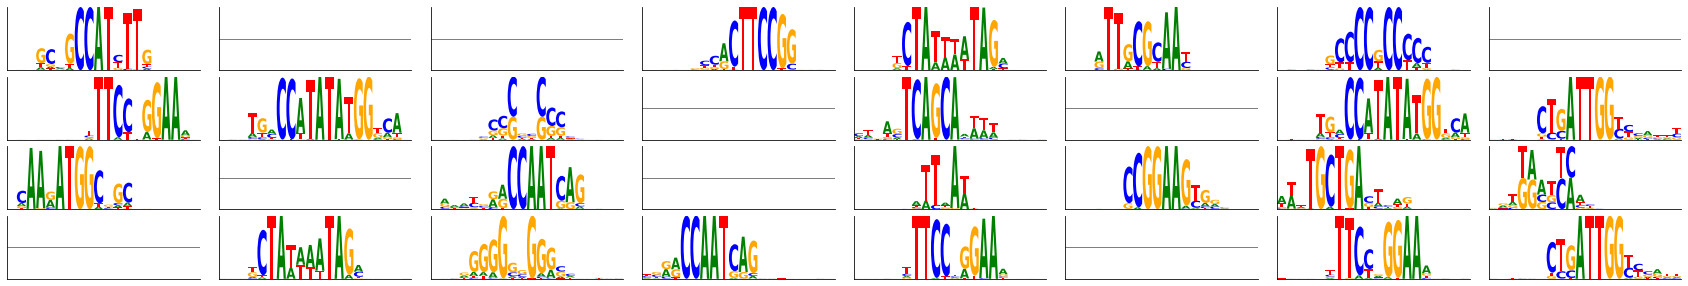

In [66]:

# get 1st convolution layer filters
layer = 3
fig, W, logo = explain.plot_filers(model, x_test, layer=layer, threshold=0.5, 
                                   window=20, num_cols=8, figsize=(30,5))

invalid value encountered in double_scalars
Attempting to set identical bottom == top == 0.0 results in singular transformations; automatically expanding.


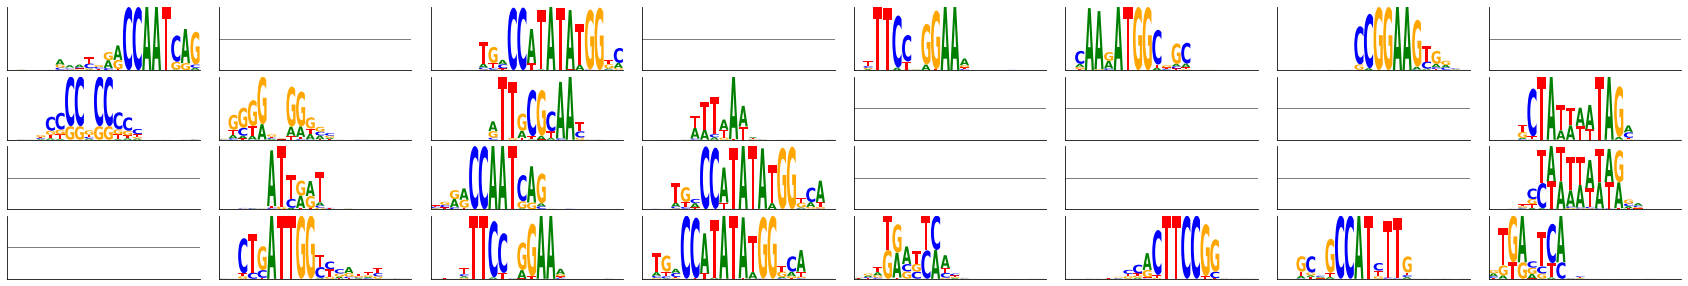

In [50]:

# get 1st convolution layer filters
layer = 3
fig, W, logo = explain.plot_filers(model, x_test, layer=layer, threshold=0.5, 
                                   window=20, num_cols=8, figsize=(30,5))

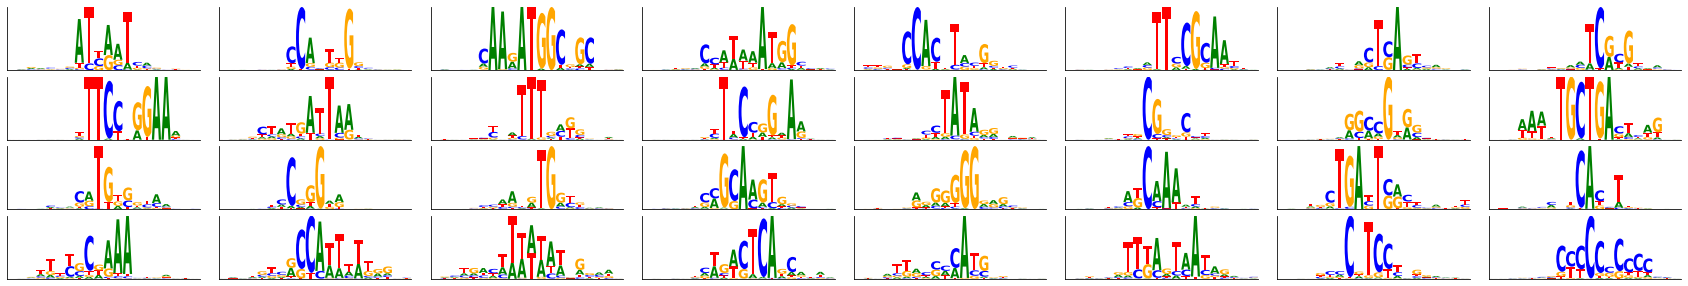

In [47]:

# get 1st convolution layer filters
layer = 3
fig, W, logo = explain.plot_filers(model, x_test, layer=layer, threshold=0.5, 
                                   window=20, num_cols=8, figsize=(30,5))

In [14]:
w = model.layers[1].get_weights()[0]
print(np.max(w**2))
print(np.min(w**2))

0.03873803
1.4506665e-10


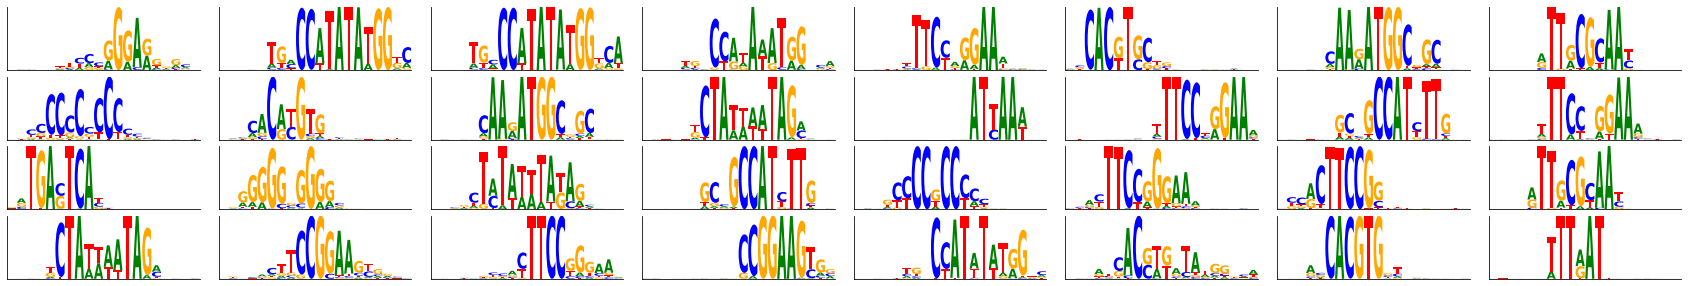

In [48]:

# get 1st convolution layer filters
layer = 3
fig, W, logo = explain.plot_filers(model, x_test, layer=layer, threshold=0.5, 
                                   window=20, num_cols=8, figsize=(30,5))

invalid value encountered in log


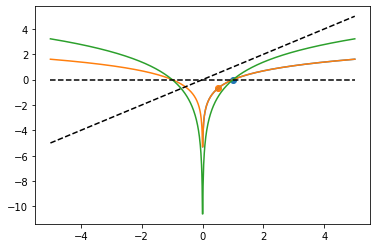

In [5]:
x = np.linspace(-5,5,1000)
plt.plot(x,np.log(x))
plt.plot(x,np.log(np.abs(x)))
plt.plot(x,np.log(x**2))
#plt.plot(x,np.log(x**2)*(x+1)*.25+.25)
plt.plot(x, np.zeros(x.shape), '--k')
plt.plot(x, x, '--k')
plt.scatter(1,0)
plt.scatter(.5, np.log(.5))

invalid value encountered in double_scalars
Attempting to set identical bottom == top == 0.0 results in singular transformations; automatically expanding.


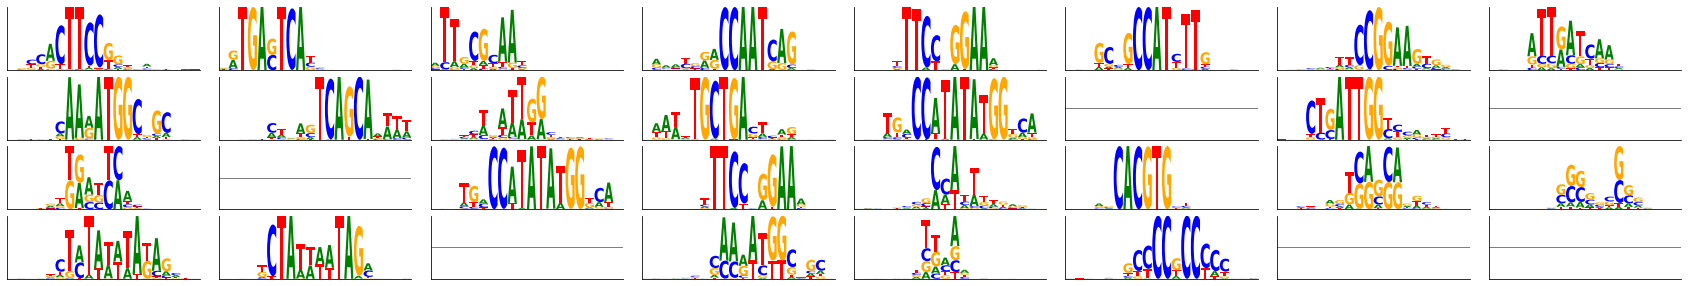

In [23]:

# get 1st convolution layer filters
layer = 3
fig, W, logo = explain.plot_filers(model, x_test, layer=layer, threshold=0.5, 
                                   window=20, num_cols=8, figsize=(30,5))

In [42]:
import tensorflow as tf
from tensorflow import keras
from keras import backend as K
from tfomics import layers, utils

class ConvPWM(keras.layers.Layer):
    def __init__(self, filters, kernel_size, background = 1/4, 
                 padding='same', strides=1, dilation_rate=1, **kwargs):
        self.filters = filters
        self.kernel_size = kernel_size
        self.background = background
        self.strides = strides
        self.dilation_rate = dilation_rate
        self.padding = padding
        
        super(ConvPWM, self).__init__(**kwargs)

    def build(self, input_shape):
        shape = [self.kernel_size, input_shape[-1], self.filters]
        self.kernel = self.add_weight(name='kernel', shape=shape,
                                      initializer=keras.initializers.RandomNormal(stddev=.05))
        #super(ConvPWM, self).build(input_shape)

    def call(self, x):
        kernel_abs = K.abs(self.kernel)
        kernel_norm = tf.math.divide(kernel_abs, K.sum(kernel_abs, axis=1, keepdims=True))
        #kernel_norm = K.softmax(, axis=1)
        conv = K.conv1d(x, kernel_norm, strides=self.strides, 
                        padding=self.padding, dilation_rate=self.dilation_rate)
        return K.log(tf.constant(4., dtype=tf.float32)*conv+1e-10)/K.log(tf.constant(2., dtype=tf.float32))
        
    def compute_output_shape(self, input_shape):
        return input_shape[:-1] + (self.filters,)

    

keras.backend.clear_session()

pool_size=[4, 25]
activation='relu'

l2 = 1e-6
dropout = [0.1, 0.1, 0.5]
bn = True
    
# input layer
inputs = keras.layers.Input(shape=(200,4))
activation = utils.activation_fn(activation)
# layer 1
nn = ConvPWM(filters=32, 
             kernel_size=19, 
             padding='same', 
             background= 1/4)(inputs)
nn = keras.layers.BatchNormalization()(nn)
nn = keras.layers.Activation(activation)(nn)
nn = keras.layers.Dropout(dropout[0])(nn)

nn = keras.layers.MaxPool1D(pool_size=pool_size[0], 
                            strides=pool_size[0], 
                            padding='same'
                            )(nn)

# layer 2
nn = layers.conv_layer(nn,
                       num_filters=124, 
                       kernel_size=5, 
                       padding='same', 
                       activation='relu', 
                       dropout=dropout[1],
                       l2=l2,
                       bn=bn)
nn = keras.layers.MaxPool1D(pool_size=pool_size[1], 
                             strides=pool_size[1], 
                             padding='same'
                             )(nn)

# Fully-connected NN
nn = keras.layers.Flatten()(nn)
nn = layers.dense_layer(nn, num_units=512, activation='relu', 
                        dropout=dropout[2], l2=l2, bn=bn)

# Output layer - additive + learned non-linearity
logits = keras.layers.Dense(12, activation='linear', use_bias=True,  
                             kernel_initializer='glorot_normal',
                             bias_initializer='zeros')(nn)
outputs = keras.layers.Activation('sigmoid')(logits)

model = keras.Model(inputs=inputs, outputs=outputs)



In [43]:

def l2_reg(weight_matrix):
    return 0.1 * K.sum(K.square(weight_matrix-.5))

# set up optimizer and metrics
auroc = keras.metrics.AUC(curve='ROC', name='auroc')
aupr = keras.metrics.AUC(curve='PR', name='aupr')
optimizer = keras.optimizers.Adam(learning_rate=0.001)
loss = keras.losses.BinaryCrossentropy(from_logits=False, label_smoothing=0)
model.compile(optimizer=optimizer,
              loss=loss,
              metrics=['accuracy', auroc, aupr])


es_callback = keras.callbacks.EarlyStopping(monitor='val_auroc', #'val_aupr',#
                                            patience=20, 
                                            verbose=1, 
                                            mode='max', 
                                            restore_best_weights=False)
reduce_lr = keras.callbacks.ReduceLROnPlateau(monitor='val_auroc', 
                                              factor=0.2,
                                              patience=5, 
                                              min_lr=1e-7,
                                              mode='max',
                                              verbose=1) 

history = model.fit(x_train, y_train, 
                    epochs=100,
                    batch_size=100, 
                    shuffle=True,
                    validation_data=(x_valid, y_valid), 
                    callbacks=[es_callback, reduce_lr])

Train on 21000 samples, validate on 3000 samples
Epoch 1/100
21000/21000 [==============================] - 2s 71us/sample - loss: 0.4777 - acc: 0.8326 - auroc: 0.5300 - aupr: 0.1590 - val_loss: 0.7194 - val_acc: 0.8557 - val_auroc: 0.5167 - val_aupr: 0.1649
Epoch 2/100
21000/21000 [==============================] - 1s 50us/sample - loss: 0.4106 - acc: 0.8558 - auroc: 0.6248 - aupr: 0.2591 - val_loss: 0.3955 - val_acc: 0.8609 - val_auroc: 0.6418 - val_aupr: 0.2973
Epoch 3/100
21000/21000 [==============================] - 1s 51us/sample - loss: 0.3699 - acc: 0.8672 - auroc: 0.7064 - aupr: 0.3769 - val_loss: 0.4014 - val_acc: 0.8629 - val_auroc: 0.6843 - val_aupr: 0.3369
Epoch 4/100
21000/21000 [==============================] - 1s 55us/sample - loss: 0.3469 - acc: 0.8740 - auroc: 0.7497 - aupr: 0.4429 - val_loss: 0.4163 - val_acc: 0.8631 - val_auroc: 0.6897 - val_aupr: 0.3476
Epoch 5/100
21000/21000 [==============================] - 1s 53us/sample - loss: 0.3328 - acc: 0.8772 - auroc:

Epoch 38/100
20000/21000 [===========================>..] - ETA: 0s - loss: 0.1628 - acc: 0.9382 - auroc: 0.9609 - aupr: 0.8617
Epoch 00038: ReduceLROnPlateau reducing learning rate to 8.000000525498762e-06.
21000/21000 [==============================] - 1s 51us/sample - loss: 0.1628 - acc: 0.9383 - auroc: 0.9608 - aupr: 0.8613 - val_loss: 0.2663 - val_acc: 0.9193 - val_auroc: 0.9300 - val_aupr: 0.8260
Epoch 39/100
21000/21000 [==============================] - 1s 53us/sample - loss: 0.1636 - acc: 0.9387 - auroc: 0.9603 - aupr: 0.8604 - val_loss: 0.2649 - val_acc: 0.9198 - val_auroc: 0.9304 - val_aupr: 0.8260
Epoch 40/100
21000/21000 [==============================] - 1s 51us/sample - loss: 0.1628 - acc: 0.9385 - auroc: 0.9609 - aupr: 0.8611 - val_loss: 0.2649 - val_acc: 0.9197 - val_auroc: 0.9302 - val_aupr: 0.8259
Epoch 41/100
21000/21000 [==============================] - 1s 52us/sample - loss: 0.1627 - acc: 0.9385 - auroc: 0.9610 - aupr: 0.8617 - val_loss: 0.2656 - val_acc: 0.9199 

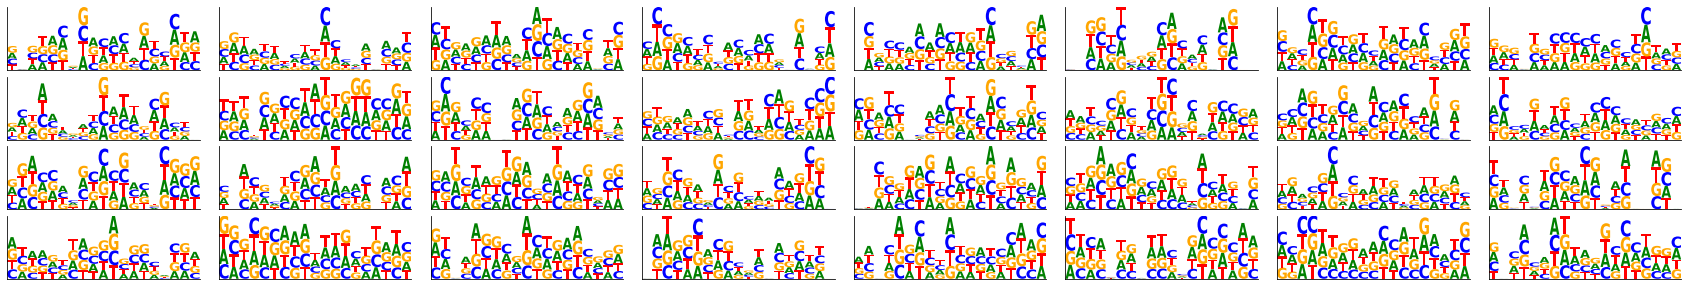

In [44]:
W = model.layers[1].get_weights()[0].transpose([2,0,1])
pfm = np.exp(W)/np.sum(np.exp(W), axis=2, keepdims=True)

plot_filers(pfm);


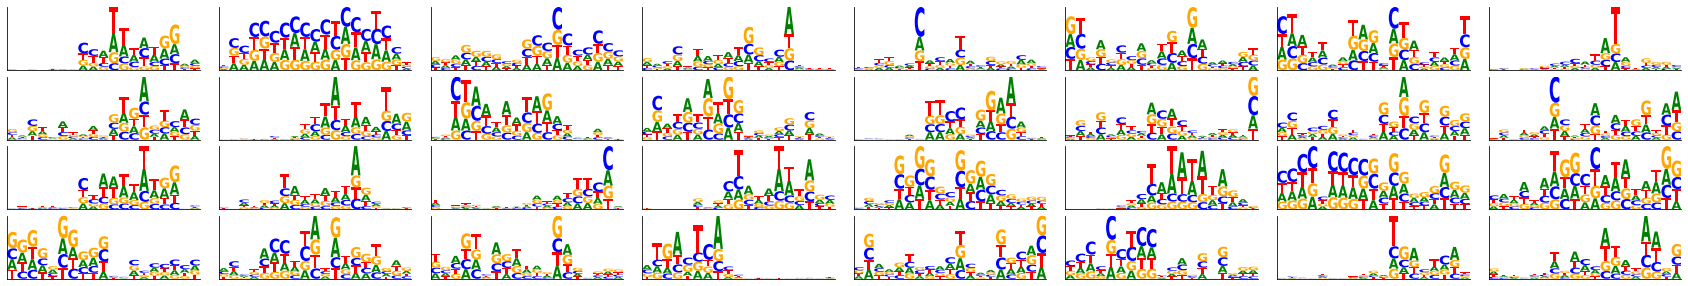

In [110]:
plot_filers(pfm);

In [111]:
import tensorflow as tf
from tensorflow import keras
from keras import backend as K
from tfomics import layers, utils

class ConvPWM(keras.layers.Layer):
    def __init__(self, filters, kernel_size, background = 1/4, 
                 padding='same', strides=1, dilation_rate=1, **kwargs):
        self.filters = filters
        self.kernel_size = kernel_size
        self.background = background
        self.strides = strides
        self.dilation_rate = dilation_rate
        self.padding = padding
        
        super(ConvPWM, self).__init__(**kwargs)

    def build(self, input_shape):
        shape = [self.kernel_size, input_shape[-1], self.filters]
        self.kernel = self.add_weight(name='kernel', shape=shape,
                                      initializer=keras.initializers.RandomNormal(stddev=1))
        super(ConvPWM, self).build(input_shape)

    def call(self, x):
        kernel_norm = K.softmax(self.kernel, axis=1)
        conv = K.conv1d(x, kernel_norm, strides=self.strides, 
                        padding=self.padding, dilation_rate=self.dilation_rate)
        return K.log(conv + 1e-12)
        
    def compute_output_shape(self, input_shape):
        return input_shape[:-1] + (self.filters,)

    

keras.backend.clear_session()

pool_size=[25, 4]
activation='relu'
multiplier=1
l2 = 1e-6

dropout_block0 = 0.1
dropout_block1 = 0.2
dropout_block2 = 0.3
dropout_block3 = 0.4
dropout_block4 = 0.5

bn = True
    
# input layer
inputs = keras.layers.Input(shape=(200,4))
activation = utils.activation_fn(activation)

# layer 1
nn = ConvPWM(filters=32, 
             kernel_size=19, 
             padding='same', 
             background= 1/4)(inputs)
nn = keras.layers.BatchNormalization()(nn)
nn = keras.layers.Activation(activation)(nn)
nn = keras.layers.Dropout(dropout_block0)(nn)
nn = keras.layers.MaxPool1D(pool_size=4, 
                            strides=4,   # 50
                            padding='same'
                            )(nn)

nn = layers.conv_layer(nn,
                       num_filters=96*multiplier, 
                       kernel_size=7,     # 44
                       padding='valid', 
                       activation='relu', 
                       dropout=dropout_block1,
                       l2=l2, 
                       bn=bn)
nn = keras.layers.MaxPool1D(pool_size=4,  # 11
                            strides=4, 
                            padding='same'
                            )(nn)

nn = layers.conv_layer(nn,
                       num_filters=128*multiplier, 
                       kernel_size=3,   # 9
                       padding='valid', 
                       activation='relu', 
                       dropout=dropout_block2,
                       l2=l2, 
                       bn=bn)
nn = keras.layers.MaxPool1D(pool_size=3,  # 3
                            strides=3, 
                            padding='same'
                            )(nn)

# Fully-connected NN
nn = keras.layers.Flatten()(nn)
nn = layers.dense_layer(nn, num_units=512, activation='relu', 
                        dropout=dropout_block4, l2=l2, bn=bn)

# Output layer
logits = keras.layers.Dense(12, activation='linear', use_bias=True,  
                             kernel_initializer='glorot_normal',
                             bias_initializer='zeros')(nn)
outputs = keras.layers.Activation('sigmoid')(logits)

model = keras.Model(inputs=inputs, outputs=outputs)



In [112]:

# set up optimizer and metrics
auroc = keras.metrics.AUC(curve='ROC', name='auroc')
aupr = keras.metrics.AUC(curve='PR', name='aupr')
optimizer = keras.optimizers.Adam(learning_rate=0.001)
loss = keras.losses.BinaryCrossentropy(from_logits=False, label_smoothing=0)
model.compile(optimizer=optimizer,
              loss=loss,
              metrics=['accuracy', auroc, aupr])


es_callback = keras.callbacks.EarlyStopping(monitor='val_auroc', #'val_aupr',#
                                            patience=20, 
                                            verbose=1, 
                                            mode='max', 
                                            restore_best_weights=False)
reduce_lr = keras.callbacks.ReduceLROnPlateau(monitor='val_auroc', 
                                              factor=0.2,
                                              patience=5, 
                                              min_lr=1e-7,
                                              mode='max',
                                              verbose=1) 

history = model.fit(x_train, y_train, 
                    epochs=100,
                    batch_size=100, 
                    shuffle=True,
                    validation_data=(x_valid, y_valid), 
                    callbacks=[es_callback, reduce_lr])

Train on 21000 samples, validate on 3000 samples
Epoch 1/100
21000/21000 [==============================] - 2s 82us/sample - loss: 0.4834 - acc: 0.8300 - auroc: 0.5266 - aupr: 0.1571 - val_loss: 0.4381 - val_acc: 0.8557 - val_auroc: 0.5179 - val_aupr: 0.1517
Epoch 2/100
21000/21000 [==============================] - 1s 55us/sample - loss: 0.4347 - acc: 0.8501 - auroc: 0.5614 - aupr: 0.1774 - val_loss: 0.4168 - val_acc: 0.8557 - val_auroc: 0.5683 - val_aupr: 0.1736
Epoch 3/100
21000/21000 [==============================] - 1s 56us/sample - loss: 0.4183 - acc: 0.8532 - auroc: 0.5902 - aupr: 0.1982 - val_loss: 0.4145 - val_acc: 0.8557 - val_auroc: 0.5815 - val_aupr: 0.1877
Epoch 4/100
21000/21000 [==============================] - 1s 57us/sample - loss: 0.4086 - acc: 0.8541 - auroc: 0.6166 - aupr: 0.2232 - val_loss: 0.4054 - val_acc: 0.8569 - val_auroc: 0.6141 - val_aupr: 0.2395
Epoch 5/100
21000/21000 [==============================] - 1s 55us/sample - loss: 0.3997 - acc: 0.8551 - auroc:

Epoch 40/100
21000/21000 [==============================] - 1s 56us/sample - loss: 0.2246 - acc: 0.9159 - auroc: 0.9192 - aupr: 0.7591 - val_loss: 0.2273 - val_acc: 0.9163 - val_auroc: 0.9226 - val_aupr: 0.7802
Epoch 41/100
21000/21000 [==============================] - 1s 55us/sample - loss: 0.2221 - acc: 0.9158 - auroc: 0.9214 - aupr: 0.7635 - val_loss: 0.2296 - val_acc: 0.9164 - val_auroc: 0.9194 - val_aupr: 0.7709
Epoch 42/100
21000/21000 [==============================] - 1s 58us/sample - loss: 0.2196 - acc: 0.9175 - auroc: 0.9230 - aupr: 0.7690 - val_loss: 0.2268 - val_acc: 0.9172 - val_auroc: 0.9216 - val_aupr: 0.7775
Epoch 43/100
21000/21000 [==============================] - 1s 57us/sample - loss: 0.2171 - acc: 0.9183 - auroc: 0.9253 - aupr: 0.7737 - val_loss: 0.2190 - val_acc: 0.9197 - val_auroc: 0.9286 - val_aupr: 0.7931
Epoch 44/100
21000/21000 [==============================] - 1s 57us/sample - loss: 0.2144 - acc: 0.9203 - auroc: 0.9269 - aupr: 0.7792 - val_loss: 0.2200 - 

Epoch 78/100
21000/21000 [==============================] - 1s 63us/sample - loss: 0.1717 - acc: 0.9369 - auroc: 0.9557 - aupr: 0.8534 - val_loss: 0.1902 - val_acc: 0.9340 - val_auroc: 0.9462 - val_aupr: 0.8434
Epoch 79/100
21000/21000 [==============================] - 1s 61us/sample - loss: 0.1708 - acc: 0.9373 - auroc: 0.9561 - aupr: 0.8552 - val_loss: 0.1899 - val_acc: 0.9339 - val_auroc: 0.9463 - val_aupr: 0.8433
Epoch 80/100
21000/21000 [==============================] - 1s 57us/sample - loss: 0.1707 - acc: 0.9371 - auroc: 0.9564 - aupr: 0.8548 - val_loss: 0.1914 - val_acc: 0.9336 - val_auroc: 0.9457 - val_aupr: 0.8428
Epoch 81/100
21000/21000 [==============================] - 1s 61us/sample - loss: 0.1684 - acc: 0.9382 - auroc: 0.9578 - aupr: 0.8580 - val_loss: 0.1903 - val_acc: 0.9344 - val_auroc: 0.9463 - val_aupr: 0.8435
Epoch 82/100
21000/21000 [==============================] - 1s 63us/sample - loss: 0.1700 - acc: 0.9374 - auroc: 0.9568 - aupr: 0.8555 - val_loss: 0.1912 - 

In [97]:
W = model.layers[1].get_weights()[0].transpose([2,0,1])
pfm = np.exp(W)/np.sum(np.exp(W), axis=2, keepdims=True)

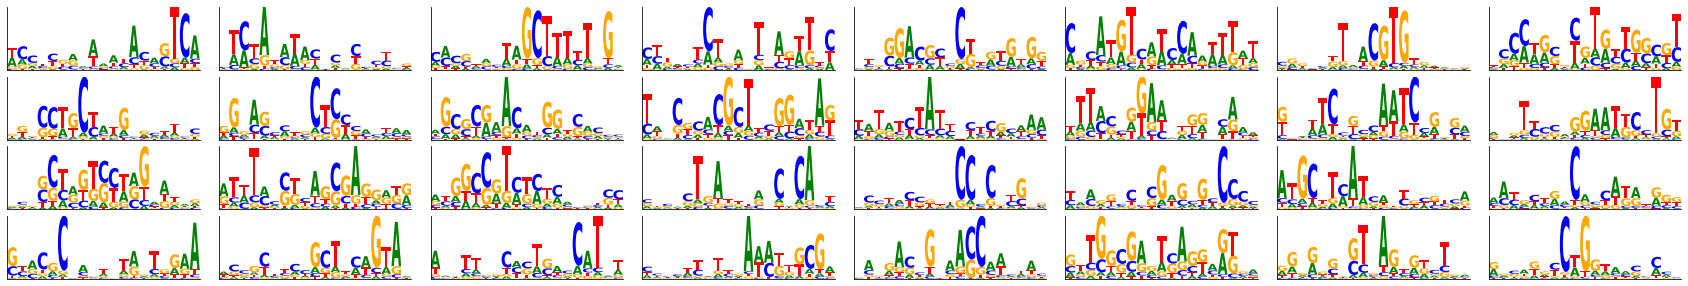

In [98]:

import pandas as pd
import logomaker

def plot_filers(W, num_cols=8, figsize=(30,5)):

    num_filters = len(W)
    num_widths = int(np.ceil(num_filters/num_cols))

    fig = plt.figure(figsize=figsize)
    fig.subplots_adjust(hspace=0.1, wspace=0.1)

    logos = []
    for n, w in enumerate(W):
        ax = fig.add_subplot(num_widths, num_cols, n+1)
        #if (np.sum(w) != 0) | (np.sum(np.isnan(w) == True) > 0):
        
        # calculate sequence logo heights
        I = np.log2(4) + np.sum(w * np.log2(w+1e-7), axis=1, keepdims=True)
        logo = I*w

        L, A = w.shape
        counts_df = pd.DataFrame(data=0.0, columns=list('ACGT'), index=list(range(L)))
        for a in range(A):
            for l in range(L):
                counts_df.iloc[l,a] = logo[l,a]

        logomaker.Logo(counts_df, ax=ax)
        ax = plt.gca()
        ax.spines['right'].set_visible(False)
        ax.spines['top'].set_visible(False)
        ax.yaxis.set_ticks_position('none')
        ax.xaxis.set_ticks_position('none')
        plt.xticks([])
        plt.yticks([])
        
        logos.append(logo)
        
    return fig, W, logo

plot_filers(pfm);

In [96]:

# get 1st convolution layer filters
layer = 2
fig, W, logo = explain.plot_filers(model, x_test, layer=layer, threshold=0.5, 
                                   window=20, num_cols=8, figsize=(30,5))

KeyboardInterrupt: 